In [1]:
# 1. Import Library yang Diperlukan
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Cek apakah GPU tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan perangkat: {device}")


Menggunakan perangkat: cuda


In [5]:
# 2. Load Dataset

# Direktori dataset
train_dir = './Dataset/train'
validation_dir = './Dataset/validation'

# Parameter
batch_size = 32
img_height = 224
img_width = 224

# Transformasi data (augmentasi dan normalisasi)
train_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # Mean untuk ImageNet
                         [0.229, 0.224, 0.225])  # Std untuk ImageNet
])

validation_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load dataset
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
validation_dataset = datasets.ImageFolder(validation_dir, transform=validation_transforms)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# Mendapatkan daftar kelas
class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Kelas: {class_names}")


Kelas: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '2', '3', '4', '5', '6', '7', '8', '9']


In [6]:
# 3. Membangun Arsitektur Model (From Scratch)

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        
        self.features = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Output: 32x224x224
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Output: 32x112x112
            
            # Convolutional Layer 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # Output: 64x112x112
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Output: 64x56x56
            
            # Convolutional Layer 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),# Output: 128x56x56
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Output: 128x28x28
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CNNModel(num_classes)
model = model.to(device)

print(model)


CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=18, bias=True)
    (5): LogSoftmax(dim=1)
  )
)


In [7]:
# 4. Kompilasi dan Training Model

# Loss function dan optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Jumlah epoch
num_epochs = 50

# Menyimpan history
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

# Loop training
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Reset gradien
        optimizer.zero_grad()
        
        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward
        loss.backward()
        optimizer.step()
        
        # Statistik
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == labels.data)
    
    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_acc = val_running_corrects.double() / len(validation_dataset)
    valid_losses.append(val_epoch_loss)
    valid_accuracies.append(val_epoch_acc.item())
    
    print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")
    
    # Early Stopping (Opsional)
    # Anda dapat menambahkan kondisi untuk menyimpan model terbaik atau menghentikan training jika tidak ada peningkatan

print("Training selesai!")


Epoch 1/50


100%|██████████| 5/5 [00:15<00:00,  3.06s/it]


Train Loss: 3.8061, Train Acc: 0.1042
Val Loss: 2.8583, Val Acc: 0.0000
Epoch 2/50


100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


Train Loss: 2.7173, Train Acc: 0.2431
Val Loss: 3.1933, Val Acc: 0.0500
Epoch 3/50


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


Train Loss: 2.2298, Train Acc: 0.3194
Val Loss: 3.6851, Val Acc: 0.0000
Epoch 4/50


100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


Train Loss: 1.7698, Train Acc: 0.4236
Val Loss: 5.0307, Val Acc: 0.0250
Epoch 5/50


100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


Train Loss: 1.1971, Train Acc: 0.6389
Val Loss: 5.3924, Val Acc: 0.0250
Epoch 6/50


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


Train Loss: 1.0061, Train Acc: 0.6458
Val Loss: 8.2752, Val Acc: 0.0250
Epoch 7/50


100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


Train Loss: 0.8099, Train Acc: 0.7431
Val Loss: 8.0465, Val Acc: 0.0000
Epoch 8/50


100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


Train Loss: 0.6052, Train Acc: 0.8403
Val Loss: 8.8045, Val Acc: 0.0250
Epoch 9/50


100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


Train Loss: 0.4919, Train Acc: 0.8403
Val Loss: 8.9217, Val Acc: 0.0500
Epoch 10/50


100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


Train Loss: 0.3503, Train Acc: 0.8611
Val Loss: 9.7914, Val Acc: 0.1250
Epoch 11/50


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


Train Loss: 0.2588, Train Acc: 0.9097
Val Loss: 12.3173, Val Acc: 0.0750
Epoch 12/50


100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


Train Loss: 0.3666, Train Acc: 0.9236
Val Loss: 12.9438, Val Acc: 0.0500
Epoch 13/50


100%|██████████| 5/5 [00:11<00:00,  2.38s/it]


Train Loss: 0.2638, Train Acc: 0.8889
Val Loss: 10.5216, Val Acc: 0.0750
Epoch 14/50


100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


Train Loss: 0.2399, Train Acc: 0.9444
Val Loss: 9.7422, Val Acc: 0.1250
Epoch 15/50


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


Train Loss: 0.2918, Train Acc: 0.9236
Val Loss: 12.0118, Val Acc: 0.0500
Epoch 16/50


100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


Train Loss: 0.1933, Train Acc: 0.9583
Val Loss: 10.8713, Val Acc: 0.1250
Epoch 17/50


100%|██████████| 5/5 [00:12<00:00,  2.47s/it]


Train Loss: 0.2629, Train Acc: 0.9236
Val Loss: 12.4246, Val Acc: 0.1250
Epoch 18/50


100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


Train Loss: 0.1210, Train Acc: 0.9514
Val Loss: 16.1657, Val Acc: 0.0250
Epoch 19/50


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


Train Loss: 0.1969, Train Acc: 0.9444
Val Loss: 11.9536, Val Acc: 0.1500
Epoch 20/50


100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


Train Loss: 0.0998, Train Acc: 0.9722
Val Loss: 11.2867, Val Acc: 0.2000
Epoch 21/50


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


Train Loss: 0.0934, Train Acc: 0.9653
Val Loss: 10.7943, Val Acc: 0.2000
Epoch 22/50


100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


Train Loss: 0.1761, Train Acc: 0.9583
Val Loss: 11.0716, Val Acc: 0.2000
Epoch 23/50


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


Train Loss: 0.1311, Train Acc: 0.9792
Val Loss: 11.6918, Val Acc: 0.2000
Epoch 24/50


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


Train Loss: 0.0967, Train Acc: 0.9722
Val Loss: 12.2787, Val Acc: 0.2000
Epoch 25/50


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


Train Loss: 0.1002, Train Acc: 0.9861
Val Loss: 12.4830, Val Acc: 0.1500
Epoch 26/50


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


Train Loss: 0.0824, Train Acc: 0.9792
Val Loss: 14.2162, Val Acc: 0.0750
Epoch 27/50


100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


Train Loss: 0.0946, Train Acc: 0.9792
Val Loss: 18.8713, Val Acc: 0.0000
Epoch 28/50


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


Train Loss: 0.1338, Train Acc: 0.9722
Val Loss: 13.8961, Val Acc: 0.1000
Epoch 29/50


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


Train Loss: 0.0919, Train Acc: 0.9792
Val Loss: 13.3423, Val Acc: 0.2000
Epoch 30/50


100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


Train Loss: 0.2341, Train Acc: 0.9514
Val Loss: 14.2816, Val Acc: 0.2000
Epoch 31/50


100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


Train Loss: 0.0572, Train Acc: 0.9861
Val Loss: 14.6675, Val Acc: 0.1750
Epoch 32/50


100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


Train Loss: 0.1217, Train Acc: 0.9444
Val Loss: 13.1714, Val Acc: 0.1750
Epoch 33/50


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


Train Loss: 0.0740, Train Acc: 0.9653
Val Loss: 12.7303, Val Acc: 0.2000
Epoch 34/50


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


Train Loss: 0.0987, Train Acc: 0.9653
Val Loss: 12.1815, Val Acc: 0.2000
Epoch 35/50


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


Train Loss: 0.0538, Train Acc: 0.9861
Val Loss: 11.6795, Val Acc: 0.2000
Epoch 36/50


100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


Train Loss: 0.0505, Train Acc: 0.9792
Val Loss: 13.0392, Val Acc: 0.1500
Epoch 37/50


100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


Train Loss: 0.0994, Train Acc: 0.9653
Val Loss: 13.4553, Val Acc: 0.1750
Epoch 38/50


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


Train Loss: 0.1010, Train Acc: 0.9653
Val Loss: 14.9341, Val Acc: 0.1500
Epoch 39/50


100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


Train Loss: 0.0496, Train Acc: 0.9792
Val Loss: 16.1912, Val Acc: 0.1500
Epoch 40/50


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


Train Loss: 0.0384, Train Acc: 0.9792
Val Loss: 17.3650, Val Acc: 0.1250
Epoch 41/50


100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


Train Loss: 0.0536, Train Acc: 0.9792
Val Loss: 18.1930, Val Acc: 0.1500
Epoch 42/50


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


Train Loss: 0.0095, Train Acc: 1.0000
Val Loss: 18.5154, Val Acc: 0.1750
Epoch 43/50


100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


Train Loss: 0.0436, Train Acc: 0.9792
Val Loss: 18.2874, Val Acc: 0.2000
Epoch 44/50


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


Train Loss: 0.0241, Train Acc: 0.9861
Val Loss: 18.6129, Val Acc: 0.2000
Epoch 45/50


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


Train Loss: 0.0164, Train Acc: 0.9931
Val Loss: 19.8215, Val Acc: 0.2000
Epoch 46/50


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


Train Loss: 0.0374, Train Acc: 0.9861
Val Loss: 20.6088, Val Acc: 0.2000
Epoch 47/50


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


Train Loss: 0.1138, Train Acc: 0.9792
Val Loss: 20.1351, Val Acc: 0.1750
Epoch 48/50


100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


Train Loss: 0.0331, Train Acc: 0.9861
Val Loss: 17.4476, Val Acc: 0.2000
Epoch 49/50


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


Train Loss: 0.0411, Train Acc: 0.9861
Val Loss: 16.8701, Val Acc: 0.2000
Epoch 50/50


100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


Train Loss: 0.0583, Train Acc: 0.9861
Val Loss: 17.8946, Val Acc: 0.2250
Training selesai!


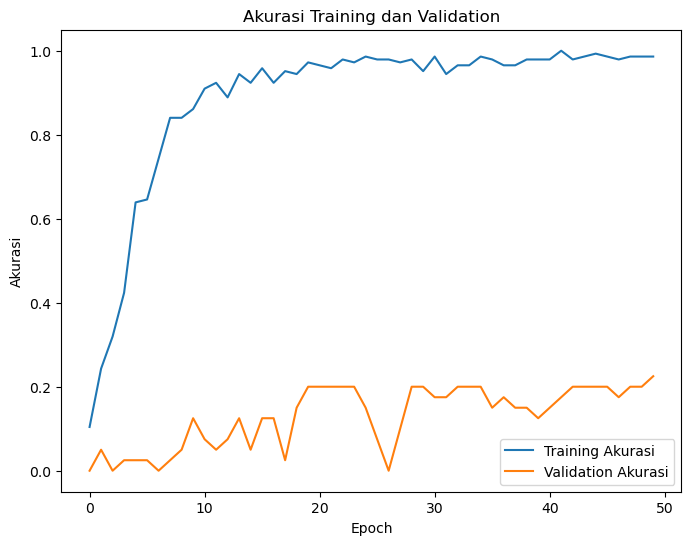

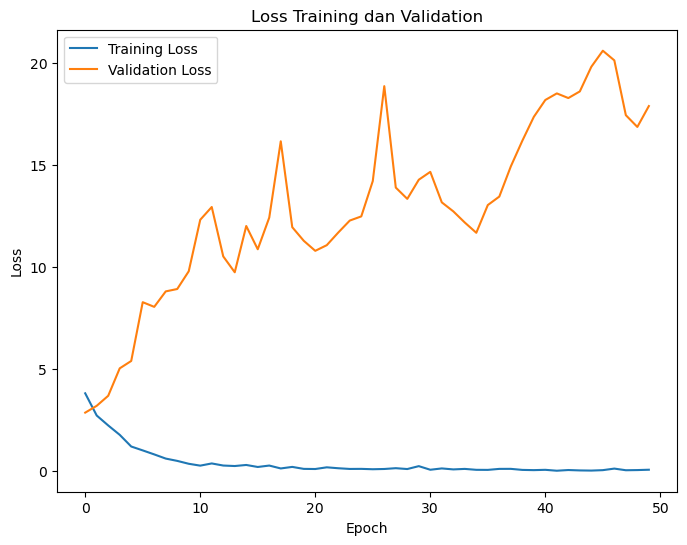

In [8]:
# 5. Visualisasi Skor Epoch

# Plot Akurasi
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Training Akurasi')
plt.plot(valid_accuracies, label='Validation Akurasi')
plt.title('Akurasi Training dan Validation')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Loss Training dan Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
